In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:17<00:00, 163MB/s]
100% 2.29G/2.29G [00:17<00:00, 139MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/chest-xray-pneumonia.zip' mode='r'>>

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import confusion_matrix

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   zoom_range = 0.2,
                                   shear_range =0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    '/content/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

X_train, y_train = train_data.next()
X_val, y_val = val_data.next()

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
(32, 224, 224, 3)
(32,)
(16, 224, 224, 3)
(16,)


In [6]:
from ast import Index
class_names = ['Normal','Pnamonia']
def show_image(X_train,y_train, index):
    y_train = y_train.astype(int)
    plt.imshow(X_train[index])
    plt.axis('off')
    plt.title(class_names[y_train[index]])
    plt.show()

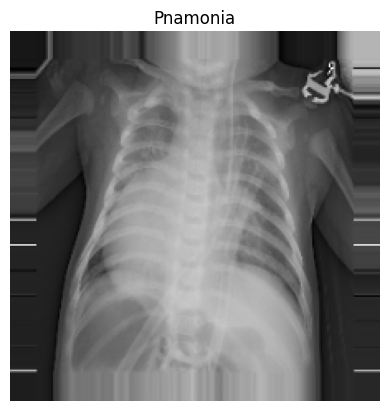

In [7]:
import random
random_index = random.randint(0,len(X_train))
show_image(X_train,y_train,random_index)

In [8]:
mbl_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
mbl_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [10]:
model = Sequential()
model.add(mbl_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
mbl_model.trainable = False

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18314817 (69.87 MB)
Trainable params: 16056833 (61.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.fit_generator(train_data, epochs=10, validation_data=val_data)

<ipython-input-14-ad580c8a385f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data, epochs=10, validation_data=val_data)


Epoch 1/10
163/163 [==============================] - 105s 600ms/step - loss: 1.0666 - accuracy: 0.9252 - val_loss: 3.9592 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 102s 625ms/step - loss: 0.2661 - accuracy: 0.9574 - val_loss: 0.7601 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 96s 589ms/step - loss: 0.1861 - accuracy: 0.9597 - val_loss: 0.6939 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 95s 582ms/step - loss: 0.1007 - accuracy: 0.9668 - val_loss: 0.1562 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 96s 591ms/step - loss: 0.0594 - accuracy: 0.9780 - val_loss: 0.1972 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 97s 596ms/step - loss: 0.0692 - accuracy: 0.9745 - val_loss: 0.2118 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 97s 597ms/step - loss: 0.0464 - accuracy: 0.9831 - val_loss: 0.2482 - val_

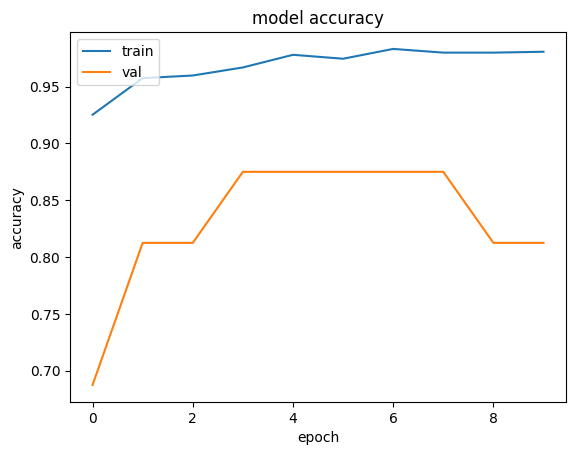

In [15]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

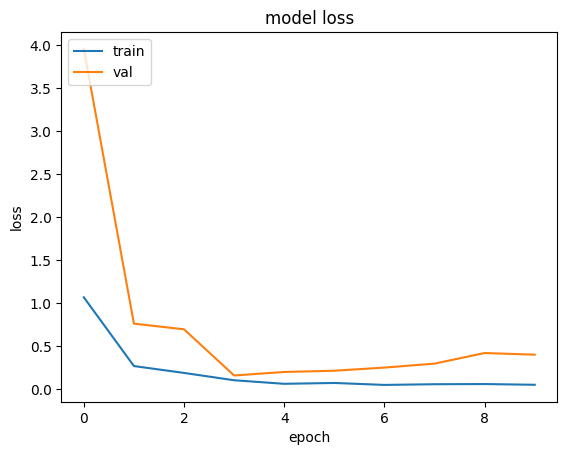

In [16]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model.evaluate_generator(val_data)

<ipython-input-17-79d23f36e8bf>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_data)


[0.3984721601009369, 0.8125]

In [18]:
model.evaluate(X_val, y_val)

1/1 [==============================] - 0s 101ms/step - loss: 0.3985 - accuracy: 0.8125


[0.3984721302986145, 0.8125]

In [19]:
model.save('TL_X_rays_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


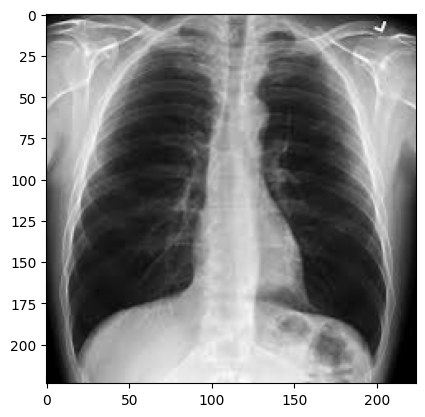

1/1 [==============================] - 0s 21ms/step
Prediction: Normal


In [37]:
from re import T
from PIL import Image
image = Image.open('/content/normal.jpeg')
image = image.resize((224,224))
image = np.array(image)
image = image/255
image = np.expand_dims(image, axis=0)
plt.imshow(image[0])
plt.show()
prediction = model.predict(image)
if prediction[0] > 0.5:
    print("Prediction: Pneumonia")
else:
    print("Prediction: Normal")

In [39]:
val_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [59]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')


Found 624 images belonging to 2 classes.


In [61]:
model.evaluate(test_data)

20/20 [==============================] - 6s 276ms/step - loss: 0.3934 - accuracy: 0.8910


[0.3933904469013214, 0.8910256624221802]

In [46]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5))

cm = confusion_matrix(true_labels, pred_labels)

20/20 [==============================] - 5s 228ms/step


In [56]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

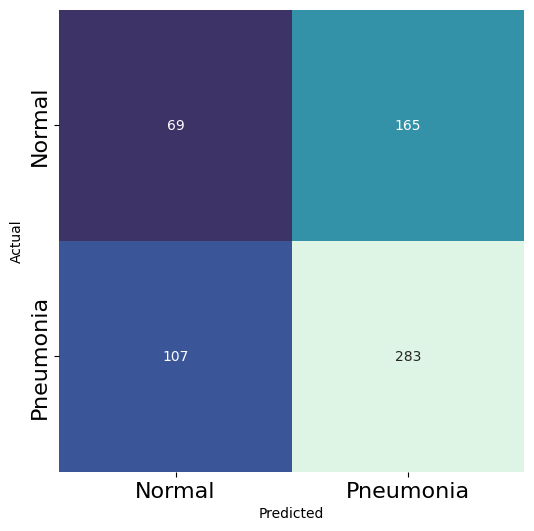

In [58]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [52]:
results = model.evaluate(test_data)

accuracy = results[1]
# auc = results[2]

20/20 [==============================] - 5s 237ms/step - loss: 0.3934 - accuracy: 0.8910


In [53]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [55]:
print("Accuracy: {:.2f}".format(accuracy))
# print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.89
Precision: 0.63
Recall: 0.73
